<a href="https://colab.research.google.com/github/Jbridg12/Alzheimer_GAN/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Notebook

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [4]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [5]:
# Extract trained GAN - uncomment as necessary
# from zipfile import ZipFile
# with ZipFile('gen1.zip', 'r') as zipper:
#  zipper.extractall()

Note: Operates under the assumption that dataset is in home directory of google drive.

# Loading Dataset

In [6]:
from os import listdir
from os.path import join, isdir
class_name = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
n_classes = len(class_name)
print(n_classes)

4


In [7]:
# Checks for corrupt files in dataset
# From https://opensource.com/article/17/2/python-tricks-artists
from os import listdir
from PIL import Image

bad_files = []
for dir in listdir('Dataset/'):
  for file in listdir('Dataset/'+dir):
    # print(file)
    # break
    if file.endswith('.jpg'):
      try:
        img = Image.open('Dataset/'+dir+'/'+file)
        img.verify()
      except (IOError, SyntaxError) as e:
        print('Bad file:', file)
        path = 'Dataset/'+dir+'/'+file
        bad_files.append(path)

In [8]:
# Removes corrupted files
print(len(bad_files))
for file in bad_files:
  os.remove(file)

0


In [9]:
# For replicable results
SEED = 0
# Size of Latent Input
noise_dim = 100
num_examples_to_generate = 16
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 32
# Images are grayscale
COLOR_MODE = "grayscale"

# Generate Images

In [13]:
# Clear any previously generated images
from os import listdir
from PIL import Image

def remove_gen_images():
  count = 0
  for dir in listdir('Dataset/'):
    for file in listdir('Dataset/'+dir):
      if 'Gen' in file:
        count += 1
        os.remove('Dataset/'+dir+'/'+file)

  print(f'Removed {count} files.')

remove_gen_images()

Removed 800 files.


### Generate One Image

In [14]:
# Load trained model
generator = tf.keras.models.load_model('./gen1')

In [15]:
def get_image(target, training=False):
  test_noise = tf.random.normal([1, noise_dim]).numpy()
  tst_in = []
  tst_in.append(np.append(test_noise[0], target))
  test_input = tf.convert_to_tensor(np.array(tst_in))

  # Generate images
  img = generator(test_input, training=training)

  return img

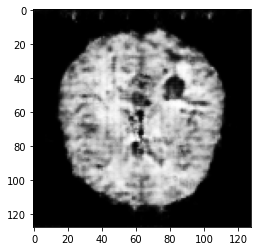

In [16]:
gen_img = get_image(1, training=False)
plt.clf()
plt.imshow(gen_img[0,:,:,0], cmap='gray')

### Generate Multiple Images

In [17]:
remove_gen_images()

Removed 0 files.


Generates 20 images and loads them into corresponding target files.

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']


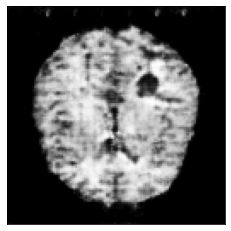

In [18]:
# Generates a given number of images
num_images = 800
target_names = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
print(target_names)

num_targets = np.random.randint(0, 4, num_images)
for i in range(num_images):
  target = num_targets[i]

  new_image = get_image(target, training=False)

  # Plot and save images
  plt.clf()
  plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
  plt.imshow(new_image[0,:,:,0], cmap='gray')
  plt.savefig('Dataset/'+target_names[target]+'/Gen_'+str(i)+'.jpg')

Give time for images to be saved and loaded into the drive.

In [19]:
from time import sleep

sleep(20)

Load training data that includes GAN generated images.

In [20]:
# If cells run sequentially should now contain true and generated images
gan_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/',
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 7199 files belonging to 4 classes.
Using 5760 files for training.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Load testing data that includes GAN generated images.

In [21]:
# If cells run sequentially should now contain true and generated images
gan_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset/',
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 7199 files belonging to 4 classes.
Using 1439 files for validation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


# Classifiers

In [22]:
# Epoch-Loss Plots

def epoch_loss(hist, axis=None):
  plt.figure()
  plt.title('Epoch-Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  if axis is not None:
    plt.ylim(0, axis)

  plot_loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.xticks(np.arange(0, len(plot_loss)+2, 2))
  plt.plot(range(len(plot_loss)), plot_loss)
  plt.plot(range(len(plot_loss)), val_loss)
  plt.legend(['Loss', 'Val Loss'])
  plt.show()

def acc_loss(hist, axis=None):
  plot_loss = hist.history['loss']
  plot_acc = hist.history['accuracy']

  val_loss = hist.history['val_loss']
  val_acc = hist.history['val_accuracy']

  plt.figure()
  if axis is not None:
    plt.ylim(0, axis)
  plt.title('Accuracy-Loss')
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.plot(plot_acc, plot_loss)
  plt.plot(val_acc, val_loss)
  plt.legend(['Acc-Loss', 'Val Acc-Val Loss'])
  plt.show()

def epoch_acc(hist, axis=None):
  plot_acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  plt.figure()
  if axis is not None:
    plt.ylim(0, axis)
  plt.title('Epoch-Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(np.arange(0, len(plot_acc)+2, 2))
  plt.plot(range(len(plot_acc)), plot_acc)
  plt.plot(range(len(plot_acc)), val_acc)
  plt.legend(['Accuracy', 'Val Accuracy'])
  plt.show()

### Classic Classifier

In [23]:
def train_cmodel(gan_train_data, gan_test_data, epochs):
  # Basic classifier taken from https://www.tensorflow.org/tutorials/load_data/images for testing
  cmodel = tf.keras.Sequential()
  cmodel.add(layers.Conv2D(32, 3, activation='relu'))
  cmodel.add(layers.MaxPool2D())
  cmodel.add(layers.Conv2D(64, 3, activation='relu'))
  cmodel.add(layers.MaxPool2D())
  cmodel.add(layers.Conv2D(32, 3, activation='relu'))
  cmodel.add(layers.MaxPool2D())
  cmodel.add(layers.Flatten())
  cmodel.add(layers.Dense(128, activation='relu'))
  cmodel.add(layers.Dense(4, 'softmax'))

  cmodel.compile(optimizer='adam',
                loss=tf.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  cmodel.fit(gan_train_data, validation_data=gan_test_data, epochs=epochs)

  return cmodel

In [24]:
classic_model = train_cmodel(gan_train_data, gan_test_data, 20)

Epoch 1/2
180/180 [==============================] - 167s 924ms/step - loss: 2.3960 - accuracy: 0.4686 - val_loss: 0.9894 - val_accuracy: 0.5177
Epoch 2/2
180/180 [==============================] - 151s 839ms/step - loss: 0.9964 - accuracy: 0.5276 - val_loss: 0.9615 - val_accuracy: 0.5733


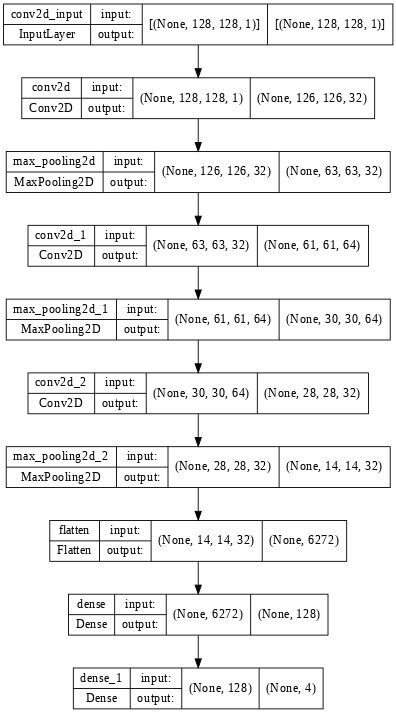

In [25]:
tf.keras.utils.plot_model(classic_model, show_shapes=True, dpi=64)

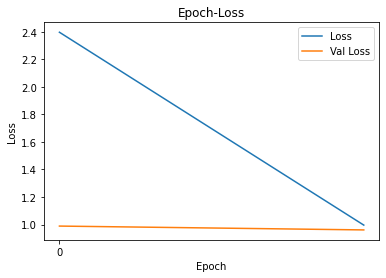

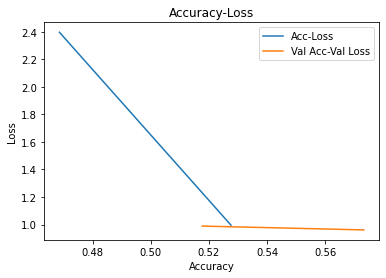

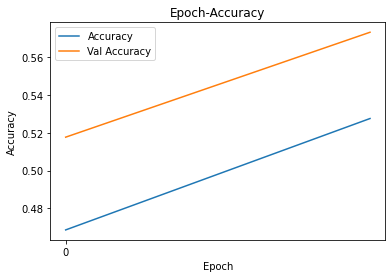

In [26]:
epoch_loss(classic_model.history)
acc_loss(classic_model.history)
epoch_acc(classic_model.history)

### Single Convolution Layer Classifier

In [28]:
def train_conv_model(gan_train_data, gan_test_data, epochs):
  dmodel = tf.keras.Sequential()
  dmodel.add(layers.Conv2D(32, 3))

  dmodel.add(layers.Flatten())
  dmodel.add(layers.Activation('relu'))
  dmodel.add(layers.Dense(4, 'softmax'))

  dmodel.compile(optimizer='adam',
                loss=tf.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  dmodel.fit(gan_train_data, validation_data=gan_test_data,epochs=epochs)

  return dmodel

In [29]:
conv_model = train_conv_model(gan_train_data, gan_test_data, 20)

Epoch 1/2
180/180 [==============================] - 57s 317ms/step - loss: 362.1973 - accuracy: 0.5569 - val_loss: 6.4912 - val_accuracy: 0.7436
Epoch 2/2
180/180 [==============================] - 57s 313ms/step - loss: 3.2985 - accuracy: 0.8122 - val_loss: 4.3582 - val_accuracy: 0.6998


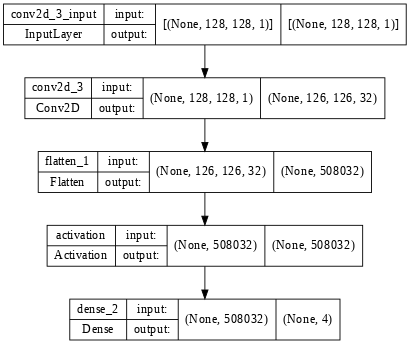

In [30]:
tf.keras.utils.plot_model(conv_model, show_shapes=True, dpi=64)

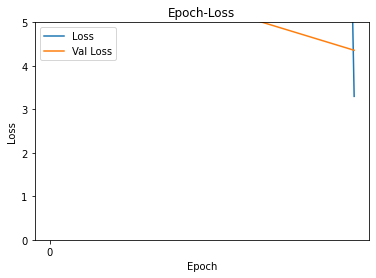

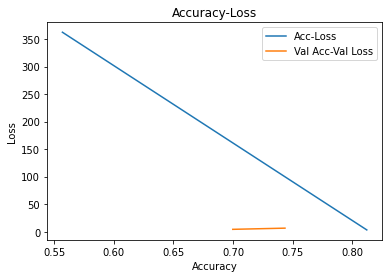

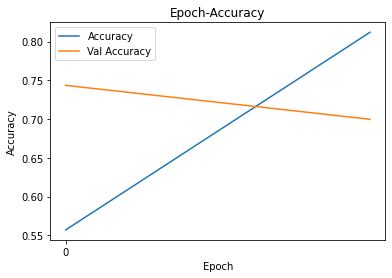

In [31]:
epoch_loss(conv_model.history, 5)
acc_loss(conv_model.history)
epoch_acc(conv_model.history)

In [32]:
# Generates a given number of images
num_images = 50
target_names = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
print(target_names)

num_targets = np.random.randint(0, 4, num_images)
print(num_targets)
img_list = []
for i in range(num_images):
  target = num_targets[i]

  gen_image = get_image(target, training=False)
  img_list.append(gen_image)

  pred = classic_model.predict(gen_image)
  print(pred)
  print(f'Predicted: {np.argmax(pred)}  |   True: {target}')

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']
[1 3 3 1 2 3 1 2 0 2 1 2 1 0 2 0 2 1 0 3 3 1 0 1 3 3 0 3 2 0 2 3 2 3 3 2 2
 3 3 1 0 0 2 2 1 1 1 2 1 3]
[[0.25313136 0.23460688 0.2452931  0.26696867]]
Predicted: 3  |   True: 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[0.2536479  0.23415121 0.2456203  0.26658052]]
Predicted: 3  |   True: 3
[[0.25337002 0.23449403 0.24546045 0.26667553]]
Predicted: 3  |   True: 3
[[0.25325525 0.2346161  0.24519126 0.2669374 ]]
Predicted: 3  |   True: 1
[[0.25361443 0.23452227 0.24530989 0.26655343]]
Predicted: 3  |   True: 2
[[0.25322348 0.23449807 0.24538484 0.2668936 ]]
Predicted: 3  |   True: 3
[[0.25309318 0.23462123 0.2453817  0.26690388]]
Predicted: 3  |   True: 1
[[0.25365862 0.23445378 0.2453537  0.26653385]]
Predicted: 3  |   True: 2
[[0.25339162 0.23483044 0.24524781 0.2665301 ]]
Predicted: 3  |   True: 0
[[0.25321284 0.234527   0.24535553 0.26690465]]
Predicted: 3  |   True: 2
[[0.2532758  0.23439872 0.24532817 0.2669973 ]]
Predicted: 3  |   True: 1
[[0.253206   0.23491728 0.24518928 0.26668748]]
Predicted: 3  |   True: 2
[[0.25353372 0.23464766 0.24518427 0.26663443]]
Predicted: 3  |   True: 1
[[0.25336978 0.23446748 0.24510619 0.26705658]]
Predicted: 3  |   True: 0
[[0.25330275 0.23412155 0.2455879  0.2

In [33]:
num_images = 20
target_names = np.array([f for f in listdir('./Dataset') if isdir(join('./Dataset', f))])
print(target_names)

num_targets = np.random.randint(0, 4, num_images)
for i in range(num_images):
  target = num_targets[i]

  new_image = get_image(target, training=False)

  pred_val = classic_model.predict(new_image)

  print(f'Predicted: {np.argmax(pred_val)}   | Actual: {target}')

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']
Predicted: 3   | Actual: 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Predicted: 3   | Actual: 3
Predicted: 3   | Actual: 3
Predicted: 3   | Actual: 3
Predicted: 3   | Actual: 2
Predicted: 3   | Actual: 1
Predicted: 3   | Actual: 1
Predicted: 3   | Actual: 2
Predicted: 3   | Actual: 0
Predicted: 3   | Actual: 0
Predicted: 3   | Actual: 2
Predicted: 3   | Actual: 0
Predicted: 3   | Actual: 0
Predicted: 3   | Actual: 2
Predicted: 3   | Actual: 3
Predicted: 3   | Actual: 1
Predicted: 3   | Actual: 3
Predicted: 3   | Actual: 0
Predicted: 3   | Actual: 3
Predicted: 3   | Actual: 3


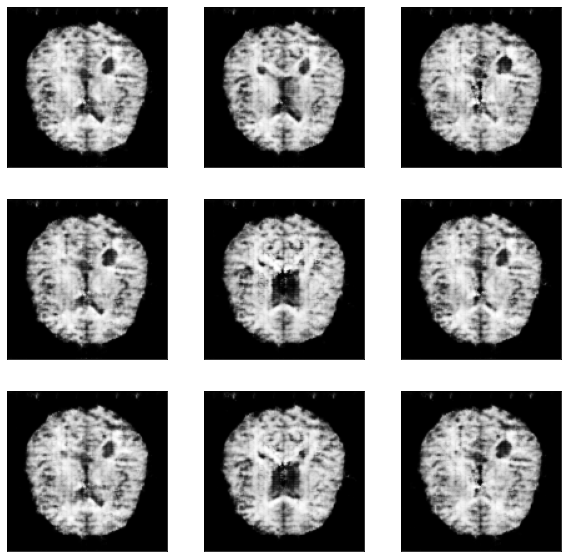

In [34]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
  plt.imshow(img_list[i][0,:,:,0], cmap='gray')